In [1]:
# Importing libraries
# Importando librerías
import re
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Function to extract date, time, author, and message
# Función para extraer fecha, hora, autor y mensaje
def extractData(s):
    pattern = '^\[(\u200e*\d+/\d+/\d+)\s+(\d+:\d+:\d+)\]\s+(.*?):\s+(.*)$'
    result = re.search(pattern, s)
    if result:
      date = result.group(1)
      time = result.group(2)
      author = result.group(3)
      message = result.group(4)
      return date, time, author, message
    return False

In [3]:
extractData('[15/03/20 18:11:13] ‪Usuario_12: Esperamos que estén bien!')

('15/03/20', '18:11:13', '\u202aUsuario_12', 'Esperamos que estén bien!')

In [4]:
# Export the chat from WhatsApp. Load it.
# Exportar el chat de WhatsApp. Cargarlo.
data = []
conversation = ("/content/chat1.txt")

In [5]:
# Open the chat and extract data from each line
# Abrir chat y extraer los datos de cada línea
with open(conversation, encoding="utf-8") as fp:
    messageBuffer = []
    parsedData = []
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if extractData(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = extractData(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [6]:
# Initialising a Pandas Dataframe
# Inicializando un Dataframe de Pandas
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) 
# Check the last few rows
# Chequear las últimas filas
#df.tail(20)

In [7]:
# Formating the 'Date' column and checking info
# Darle formato de fecha a la columna 'Date' y chequeando información del DF
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     14990 non-null  datetime64[ns]
 1   Time     14990 non-null  object        
 2   Author   14990 non-null  object        
 3   Message  14990 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 468.6+ KB


In [8]:
# Checking the number of participants in the group
# Chequear la cantidad de participantes del grupo
len(df.Author.unique())

63

In [9]:
# Create a dictionary that associates each name or number to a label to change the real names
# Crear un diccionario que asocie cada nombre o número con la etiqueta correspondiente
name_dict = {}
user_num = 1
for name in df['Author'].unique():
    name_dict[name] = 'User_' + str(user_num)
    user_num += 1

df['Author'] = df['Author'].replace(name_dict)

In [10]:
# Generate Year, Month, Day and Weekday columns
# Generar columnas de año, mes, día y nombre del día
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     14990 non-null  datetime64[ns]
 1   Time     14990 non-null  object        
 2   Author   14990 non-null  object        
 3   Message  14990 non-null  object        
 4   Year     14990 non-null  int64         
 5   Month    14990 non-null  int64         
 6   Day      14990 non-null  int64         
 7   Weekday  14990 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 937.0+ KB


In [11]:
# Name the months
# Poner nombres de los meses

df['Month'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace=True)

In [12]:
df['Weekday'].head(20)

0     Wednesday
1     Wednesday
2      Thursday
3      Thursday
4      Thursday
5      Thursday
6      Thursday
7      Thursday
8      Thursday
9      Thursday
10     Thursday
11     Thursday
12     Thursday
13     Thursday
14     Thursday
15     Thursday
16     Thursday
17     Thursday
18     Thursday
19       Friday
Name: Weekday, dtype: object

In [13]:
# Checking number of rows per year
# Chequeando la cantidad de filas por año
df.Year.value_counts()

2021    7428
2022    6864
2023     696
2018       2
Name: Year, dtype: int64

In [14]:
# Filtering for the year 2022
# Filtrando el año 2022
df1 = df[df.Year == 2022]

In [15]:
# Some group stats 
# Algunas estadísticas del grupo
total_messages = df1.shape[0]
audio_messages = df1[df1['Message'] == 'audio omitido'].shape[0]
media_messages = df1[df1['Message'] == 'imagen omitida'].shape[0]
stickers = df1[df1['Message'] == 'sticker omitido'].shape[0]
gifs = df1[df1['Message'] == 'GIF omitido'].shape[0]

print("Total messages in the group:",total_messages)
print("Total media in the group:",media_messages)
print('Total audio messages in the group is: ',  audio_messages)
print('Total stickers in the group is: ',  stickers)
print('Total GIFs in the group is: ',  gifs)

Total messages in the group: 6864
Total media in the group: 494
Total audio messages in the group is:  162
Total stickers in the group is:  85
Total GIFs in the group is:  9


In [16]:
# Create a new DF to add new columns to count the number of words and letters in each message
# Crear un nuevo DF para luego agregar columnas para contar cantidad de palabras y letras de cada mensaje
media_messages_df = df1[df1['Message'] == 'imagen omitida']
messages_df = df1.drop(media_messages_df.index)
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6370 entries, 7430 to 14293
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     6370 non-null   datetime64[ns]
 1   Time     6370 non-null   object        
 2   Author   6370 non-null   object        
 3   Message  6370 non-null   object        
 4   Year     6370 non-null   int64         
 5   Month    6370 non-null   object        
 6   Day      6370 non-null   int64         
 7   Weekday  6370 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 447.9+ KB


In [17]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s: len(s) if 'audio omitido' not in s and 'imagen omitida' not in s and 'sticker omitido' not in s and 'GIF omitido' not in s and 'Tarjeta de contacto omitida' not in s else 0)
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')) if 'audio omitido' not in s and 'imagen omitida' not in s and 'sticker omitido' not in s and 'GIF omitido' not in s and 'Tarjeta de contacto omitida' not in s else 0)
messages_df["MessageCount"]=1

messages_df.head(2)

,Date,Time,Author,Message,Year,Month,Day,Weekday,Letter_Count,Word_Count,MessageCount
7430,2022-01-02,18:18:33,User_3,audio omitido,2022,Jan,2,Sunday,0,0,1
7432,2022-01-03,08:02:31,User_45,Ojalá!!!!!,2022,Jan,3,Monday,10,1,1


In [18]:
omitted = ['imagen omitida', 'audio omitido', 'sticker omitido', 'GIF omitido', 'Tarjeta de contacto omitida']
media_messages_df = df1[df1['Message'].isin(omitted)]
messages_df = df1.drop(media_messages_df.index)

messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6091 entries, 7432 to 14293
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     6091 non-null   datetime64[ns]
 1   Time     6091 non-null   object        
 2   Author   6091 non-null   object        
 3   Message  6091 non-null   object        
 4   Year     6091 non-null   int64         
 5   Month    6091 non-null   object        
 6   Day      6091 non-null   int64         
 7   Weekday  6091 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 428.3+ KB


In [19]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

#messages_df.tail(2)

In [20]:
messages_df.Letter_Count.value_counts()

8      162
24     153
7      145
12     143
9      139
      ... 
221      1
231      1
387      1
321      1
216      1
Name: Letter_Count, Length: 330, dtype: int64

Text(0.5, 1.0, 'Messages per Day')

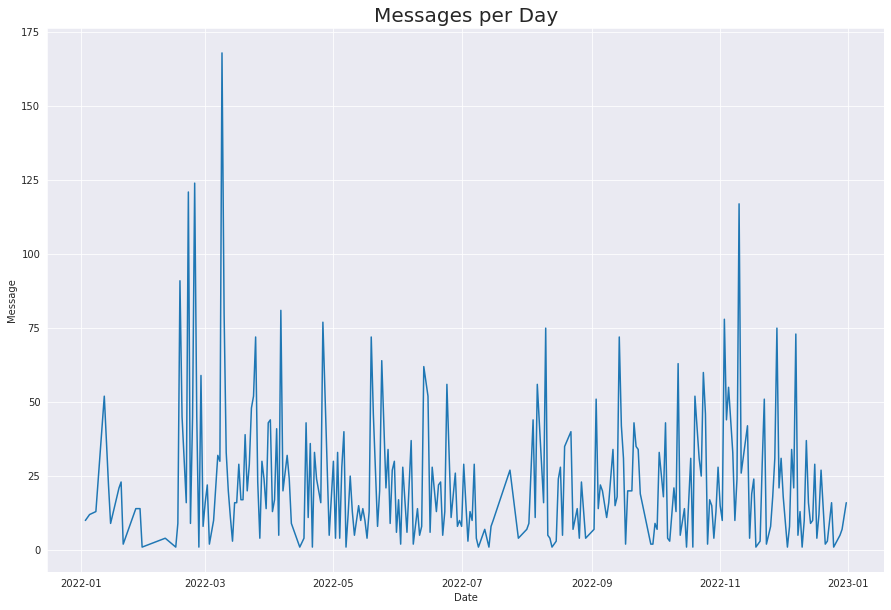

In [21]:
# Starting to plot
# Empezando a graficar
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,10))
q = sns.lineplot(data=messages_df.groupby('Date').count().reset_index(), x='Date', y='Message')
q.set_title("Messages per Day", fontsize = 20)

In [22]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

msg_per_month = df1.groupby('Month',as_index=False)['Message'].count()
msg_per_month

,Month,Message
0,Apr,618
1,Aug,429
2,Dec,498
3,Feb,598
4,Jan,202
5,Jul,195
6,Jun,544
7,Mar,1017
8,May,683
9,Nov,840


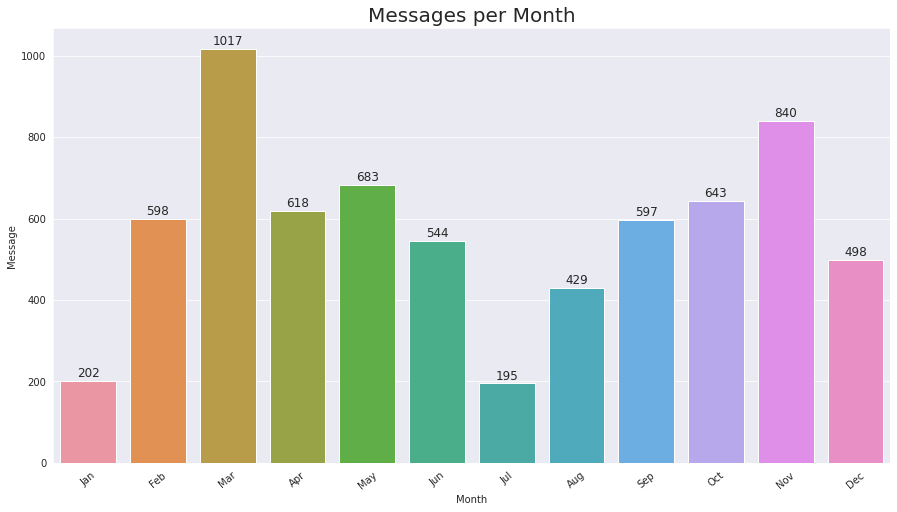

In [23]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,8))
plt.xticks(rotation=40)
p = sns.barplot(x='Month', y='Message', data=msg_per_month, order=months)
p.set_title("Messages per Month", fontsize = 20)

for i in p.patches:
    height = i.get_height()
    p.text(i.get_x() + i.get_width()/2, height+10, int(height), ha='center', fontsize=12)

In [24]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_category = pd.Categorical(df1['Weekday'], categories=weekday_order, ordered=True)

# Group and count messages by day of the week using the ordered category
# Agrupa y cuenta los mensajes por día de la semana usando la categoría ordenada
msg_per_weekday = df1.groupby(weekday_category)['Message'].count().reindex(weekday_order).to_frame().reset_index()
msg_per_weekday.columns = ['Weekday', 'Message']

msg_per_weekday

,Weekday,Message
0,Monday,1161
1,Tuesday,850
2,Wednesday,1265
3,Thursday,1277
4,Friday,1034
5,Saturday,724
6,Sunday,553


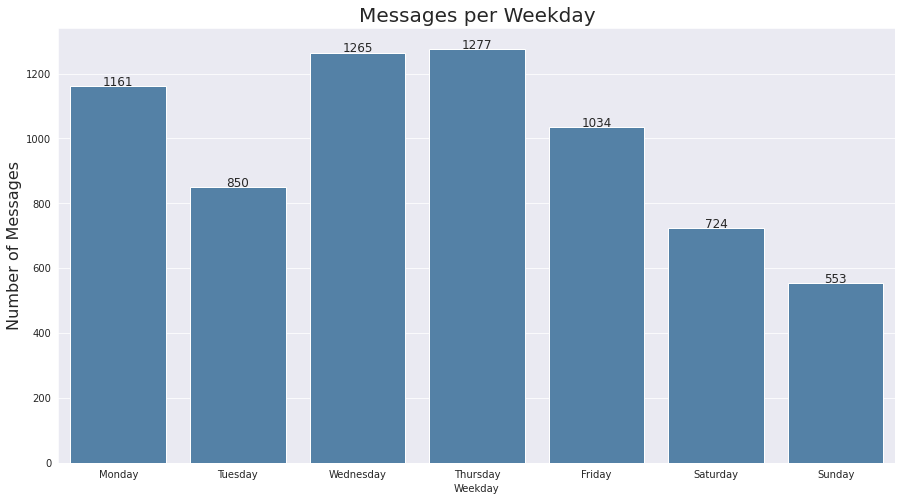

In [25]:
fig = plt.figure(figsize=(15,8))
sns.set_style('darkgrid')
sns.barplot(x='Weekday', y='Message', data=msg_per_weekday, color='steelblue')
plt.title('Messages per Weekday', fontsize=20)
plt.ylabel('Number of Messages', fontsize=16)

for index, row in msg_per_weekday.iterrows():
    plt.text(row.name, row.Message+1, row.Message, ha='center', fontsize=12)

In [26]:
# Working with Time and Hours
# Trabajando con Tiempo y horas
df1 = df1.copy()
df1.loc[:, 'Time'] = pd.to_datetime(df1['Time'])

hourly_counts = df1.groupby(df1['Time'].dt.hour)['Message'].count().reset_index()

hourly_counts

,Time,Message
0,0,11
1,6,10
2,7,89
3,8,254
4,9,324
5,10,385
6,11,492
7,12,586
8,13,601
9,14,481


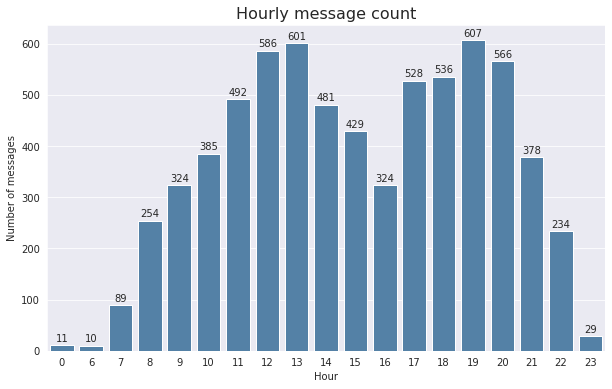

In [27]:
fig = plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
ax = sns.barplot(x='Time', y='Message', data=hourly_counts, color='steelblue')
plt.xlabel('Hour')
plt.ylabel('Number of messages')
plt.title('Hourly message count', fontsize=16)

for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=2)

plt.show()

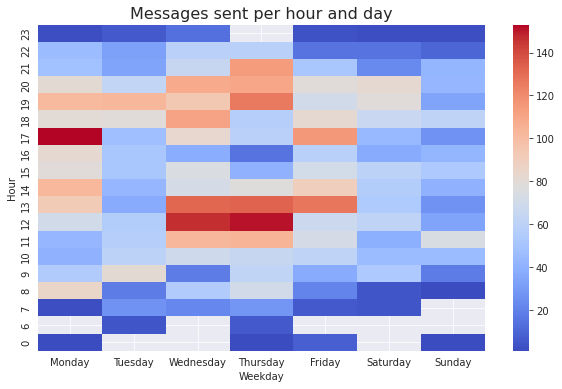

In [28]:
msg_per_hour_weekday = df1.pivot_table(index=df1['Time'].dt.hour, columns='Weekday', values='Message', aggfunc='count').reindex(columns=weekday_order)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.heatmap(msg_per_hour_weekday, cmap='coolwarm', ax=ax)

ax.set_title('Messages sent per hour and day', fontsize=16)
ax.set_ylabel('Hour')
ax.invert_yaxis()

plt.show()

In [29]:
bins = [0, 5, 12, 20, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Night']
df1['Time of Day'] = pd.cut(df1['Time'].dt.hour, bins=bins, labels=labels, include_lowest=True, ordered=False)

time_count = df1.groupby('Time of Day')['Message'].count().reset_index()
time_count

,Time of Day,Message
0,Afternoon,4072
1,Morning,2140
2,Night,652


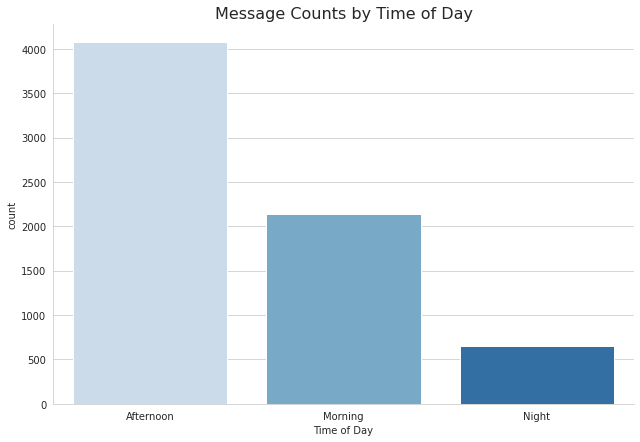

In [30]:
fig = sns.catplot(x='Time of Day', kind='count', palette='Blues', data=df1, height=6, aspect=1.5)
fig.ax.set_title('Message Counts by Time of Day', fontsize=16)

plt.show()

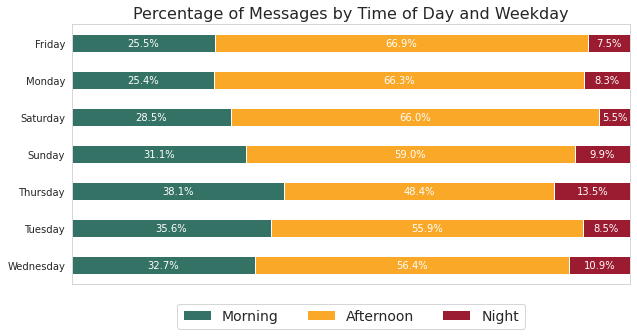

In [31]:
msg_per_hour_weekday = df1.groupby(['Weekday', 'Time of Day'])['Message'].count().reset_index()
colors = {'Morning': '#357266', 'Afternoon': '#F9A828', 'Night': '#9B1B30'}

# Calculate the percentage of each time section for each day of the week
# Calcular el porcentaje de cada sección del día para cada día de la semana
msg_per_hour_weekday_pivot = msg_per_hour_weekday.pivot(index='Weekday', columns='Time of Day', values='Message')
msg_per_hour_weekday_pct = msg_per_hour_weekday_pivot.div(msg_per_hour_weekday_pivot.sum(axis=1), axis=0)
msg_per_hour_weekday_pct = msg_per_hour_weekday_pct[['Morning', 'Afternoon', 'Night']]  # especificar el nuevo orden de las columnas

ax = msg_per_hour_weekday_pct.plot(kind='barh', stacked=True, color=[colors[x] for x in msg_per_hour_weekday_pct.columns], figsize=(10, 6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xlim(0, 1)
plt.gca().invert_yaxis()
ax.xaxis.set_visible(False)

plt.subplots_adjust(top=0.85, bottom=0.25)
plt.title('Percentage of Messages by Time of Day and Weekday', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=14)

for i, (weekday, row) in enumerate(msg_per_hour_weekday_pct.iterrows()):
    total_width = 0
    for j, (section, value) in enumerate(row.iteritems()):
        if value > 0:
            bar_width = value
            ax.text(total_width + bar_width/2, i, f'{value:.1%}', ha='center', va='center', color='white', fontsize=10)
            total_width += bar_width

plt.show()

In [32]:
# Identifying Emojis
# Identificando Emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emojis
        u"\U0001F300-\U0001F5FF"  # symbols and pictograms - símbolos y pictogramas
        u"\U0001F680-\U0001F6FF"  # transport and map symbols - transporte y símbolos de mapa
        u"\U0001F1E0-\U0001F1FF"  # country flags - banderas de países
                           "]+", flags=re.UNICODE)

# Apply the regex to each message in the dataframe
# Aplicar la regex a cada mensaje en el df
emojis = df1['Message'].apply(lambda x: emoji_pattern.findall(x))

# Joining all the emojis into a list, counting each occurrence as an individual emoji
# Unir todos los emojis en una lista, contando cada ocurrencia como un emoji individual
emoji_list = []
for sublist in emojis:
    for emoji in sublist:
        emoji_list.extend(list(emoji))
        

In [33]:
# Top 15 most used Emojis
# Top 15 Emojis más utilizados
emoji_counts = Counter(emoji_list)
top_15_emojis = emoji_counts.most_common(15)
print(top_15_emojis)

# Convert the top 15 into a dataframe to create a Treemap chart
# Convertir el top 15 en un df par ahacer un Treemap
df_top_15_emojis = pd.DataFrame(top_15_emojis, columns=['emoji', 'count'])

fig = px.treemap(df_top_15_emojis, path=['emoji'], values='count')
fig.update_layout(width=850, height=550)
fig.show()

[('😂', 209), ('😍', 164), ('🏻', 138), ('👏', 138), ('💕', 137), ('👍', 121), ('🏼', 111), ('💜', 105), ('😘', 80), ('🏽', 80), ('💚', 71), ('🎂', 55), ('🙌', 54), ('🎉', 48), ('💪', 48)]


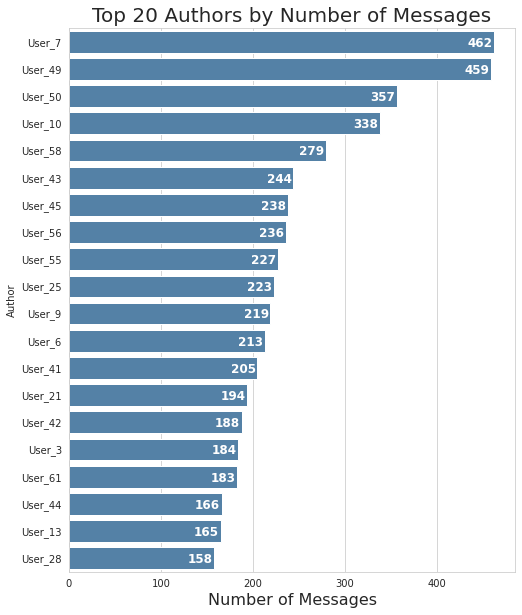

In [34]:
# Top 20 users by number of Messages
# Top 20 usuarios que maás mensajes enviaron
msg_per_author = df1.groupby('Author')['Message'].count().reset_index()
top_20 = msg_per_author.nlargest(20, 'Message')

fig = plt.figure(figsize=(8,10))
ax = sns.barplot(y='Author', x='Message', data=top_20, orient='h', color='steelblue')
plt.title('Top 20 Authors by Number of Messages', fontsize=20)
plt.xlabel('Number of Messages', fontsize=16)

for i, v in enumerate(top_20['Message']):
    ax.text(v - 29, i+.05, str(v), color='white', weight='bold', fontsize=12, ha='left', va='center')

plt.show()

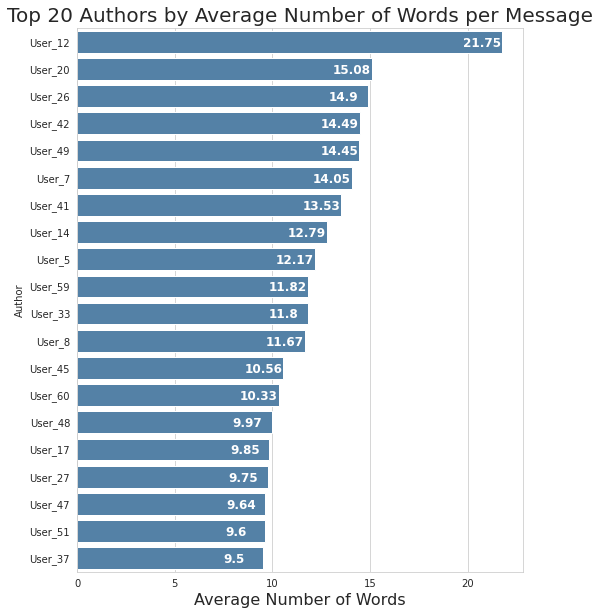

In [35]:
# Calculate the average words per author
# Calcular el promedio de palabras por autor
avg_words_per_author = messages_df.groupby('Author')['Word_Count'].mean().reset_index()
top_20_avg_words = avg_words_per_author.nlargest(20, 'Word_Count')

# Sort authors by average word count
# Ordenar los autores por el promedio de palabras
avg_words_per_author = avg_words_per_author.sort_values(by='Word_Count', ascending=False)

fig = plt.figure(figsize=(8,10))
ax = sns.barplot(x='Word_Count', y='Author', data=top_20_avg_words, orient='h', color='steelblue')
plt.title('Top 20 Authors by Average Number of Words per Message', fontsize=20)
plt.xlabel('Average Number of Words', fontsize=16)

for i, v in enumerate(top_20_avg_words['Word_Count']):
    ax.text(v - 2, i+.05, str(round(v, 2)), color='white', weight='bold', fontsize=12, ha='left', va='center')

plt.show()

In [36]:
# Install NLTK

!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import nltk
from nltk.corpus import stopwords
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

There are 314964 words in all the messages


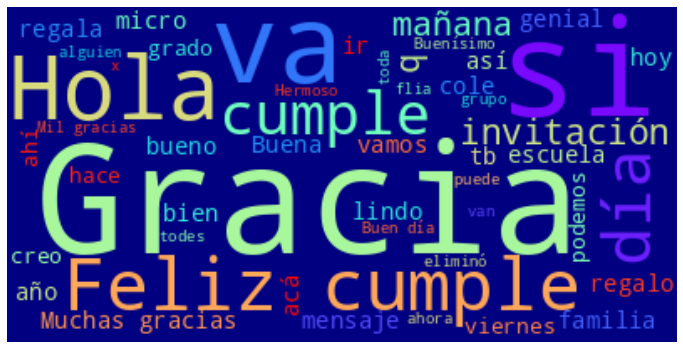

In [38]:
# Generate a word cloud image
# Generando una nube de palbras
text = " ".join(review for review in messages_df.Message)
print("There are {} words in all the messages".format(len(text)))

# Configuring the stop words (words that should not be included in the Word Cloud)
# Configurando las stop words (palabras que no deben ir dentro del Word Cloud)
stop_words = nltk.corpus.stopwords.words('spanish')
stop_words += ["\u200b", "\xa0", "ma"] 

wordcloud = WordCloud(stopwords=stop_words, background_color='navy', colormap='rainbow', max_words=50).generate(text)

plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
# Get the frequency of word occurrences
# Obtener la frecuencia de aparición de palabras
word_freq = wordcloud.process_text(text)

# Sort by frequency of appearance from highest to lowest.
# Ordenar por orden de aparición de mayor a menor
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_word_freq[:50]

for i, (word, freq) in enumerate(top_words):
    print(f"{i+1}. {word}: {freq}")

1. Gracia: 602
2. si: 458
3. va: 300
4. Hola: 295
5. Feliz cumple: 196
6. día: 155
7. cumple: 142
8. invitación: 139
9. mañana: 131
10. q: 126
11. Muchas gracias: 122
12. bueno: 120
13. regala: 114
14. año: 112
15. genial: 110
16. lindo: 108
17. familia: 106
18. ir: 105
19. acá: 103
20. hoy: 102
21. así: 101
22. micro: 97
23. vamos: 94
24. regalo: 90
25. Buena: 87
26. mensaje: 85
27. tb: 85
28. cole: 84
29. bien: 82
30. escuela: 82
31. viernes: 75
32. grado: 75
33. hace: 71
34. ahí: 70
35. creo: 69
36. podemos: 65
37. Mil gracias: 65
38. ahora: 64
39. grupo: 62
40. van: 61
41. puede: 60
42. eliminó: 60
43. Hermoso: 59
44. toda: 59
45. todes: 57
46. flia: 57
47. Buen día: 57
48. alguien: 56
49. Buenísimo: 54
50. x: 53


In [40]:
# Top 3 users with the highest number of messages sent
# Obtener el top 3 de usuarios con mayor cantidad de mensajes enviados
msg_per_author = df1.groupby('Author')['Message'].count().reset_index()
top_3_msg = msg_per_author.nlargest(3, 'Message')
top_3_msg_authors = top_3_msg['Author'].tolist()

# Top 3 users with the highest average word count
# Obtener el top 3 de usuarios con el promedio de palabras más alto
avg_words_per_author = messages_df.groupby('Author')['Word_Count'].mean().reset_index()
top_3_avg_words = avg_words_per_author.nlargest(3, 'Word_Count')
top_3_avg_words_authors = top_3_avg_words['Author'].tolist()

# Combine into a list
# Combinar los dos tops en una lista
top_6 = top_3_msg_authors + top_3_avg_words_authors

print(top_6)

['User_7', 'User_49', 'User_50', 'User_12', 'User_20', 'User_26']


In [41]:
# Stats of each user in top_6
# Estadísticas de cada usuario en top_6
for author in top_6:
    print(f'Stats of {author}:')
    messages_sent = df1[df1['Author'] == author].shape[0]
    print(f'Messages sent: {messages_sent}')
    words_per_message = round(messages_df[messages_df['Author'] == author]['Word_Count'].mean(), 2)
    print(f'Words per message: {words_per_message}')  
    audio_sent = df1[(df1['Author'] == author) & (df1['Message'] == 'audio omitido')].shape[0]
    print(f'Audio sent: {audio_sent}')
    media_sent = df1[(df1['Author'] == author) & (df1['Message'] == 'imagen omitida')].shape[0]
    print(f'Media sent: {media_sent}')
    sticker_sent = df1[(df1['Author'] == author) & (df1['Message'] == 'sticker omitido')].shape[0]
    print(f'Sticker sent: {sticker_sent}')
    gif_sent = df1[(df1['Author'] == author) & (df1['Message'] == 'GIF omitido')].shape[0]
    print(f'GIF sent: {gif_sent} \n')


Stats of User_7:
Messages sent: 462
Words per message: 14.05
Audio sent: 7
Media sent: 42
Sticker sent: 0
GIF sent: 3 

Stats of User_49:
Messages sent: 459
Words per message: 14.45
Audio sent: 6
Media sent: 23
Sticker sent: 0
GIF sent: 0 

Stats of User_50:
Messages sent: 357
Words per message: 6.94
Audio sent: 3
Media sent: 20
Sticker sent: 6
GIF sent: 0 

Stats of User_12:
Messages sent: 6
Words per message: 21.75
Audio sent: 1
Media sent: 1
Sticker sent: 0
GIF sent: 0 

Stats of User_20:
Messages sent: 79
Words per message: 15.08
Audio sent: 1
Media sent: 24
Sticker sent: 4
GIF sent: 1 

Stats of User_26:
Messages sent: 10
Words per message: 14.9
Audio sent: 0
Media sent: 0
Sticker sent: 0
GIF sent: 0 

